
## 데이터 https://goo.gl/s8qSL5

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
%matplotlib inline

In [68]:
train = pd.read_csv("data/bike_train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


## datetime 데이터 분해

In [70]:
train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day", "d-hour", "d-minute", "d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


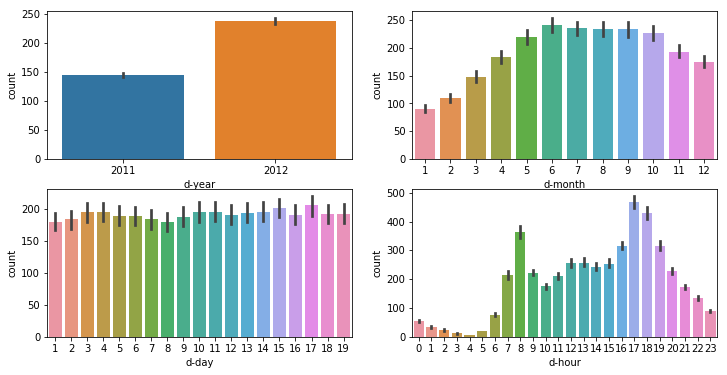

In [71]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 6)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)
sns.barplot(data=train, x="d-day", y="count", ax=ax3)
sns.barplot(data=train, x="d-hour", y="count", ax=ax4)

## 시간대별 평균 대여수 (주중, 주말 구분)

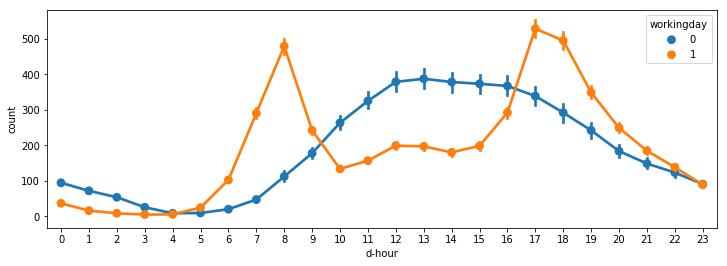

In [41]:
plt.figure(figsize=(12,4))
sns.pointplot(data=train, x="d-hour", y="count", hue="workingday")

## 시간대별 대여수 - 요일 구분

In [42]:
train["d-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


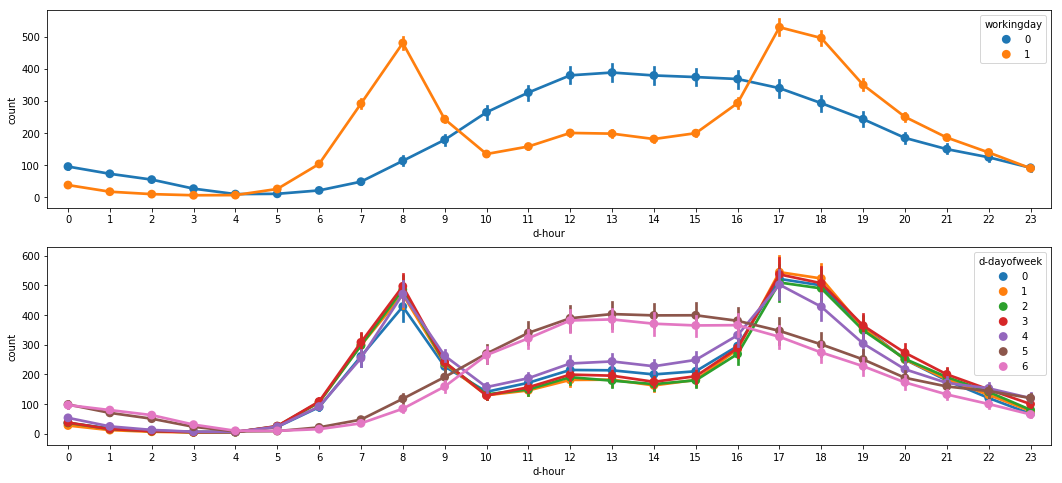

In [43]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

sns.pointplot(data=train, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=train, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 연도와 월을 합한 특성 변수 생성

In [44]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["d-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "d-year_month"]].head()

(10886, 20)


,datetime,d-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


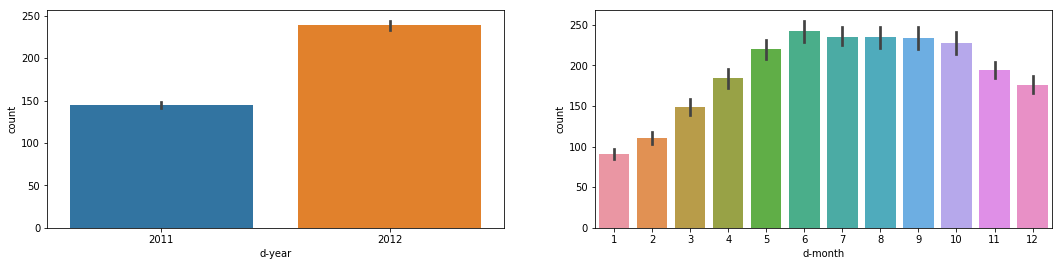

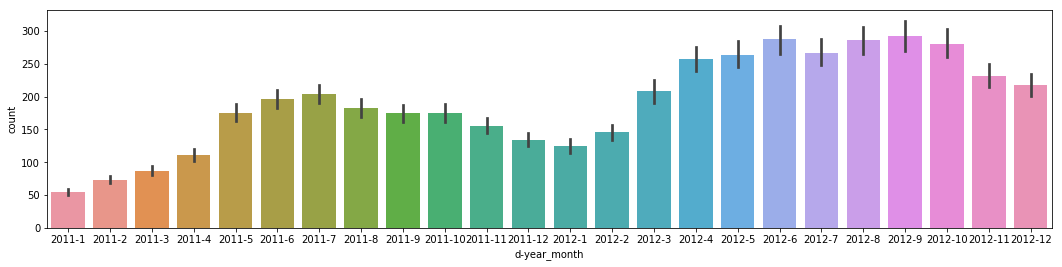

In [45]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year_month", y="count", ax=ax3)

## 훈련에 사용할 특성 선택

In [46]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-minute', 'd-second',
       'd-dayofweek', 'd-year_month'],
      dtype='object')

In [47]:
features = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "d-year", "d-hour", "d-dayofweek"]

In [48]:
X = train[features]
print(X.shape)
X.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [49]:
y = train["count"]
print(y.shape)

(10886,)


In [50]:
# import numpy as np
# y_train = np.log(y_train + 1)

# print(y_train.shape)
# y_train.head()

## 간단한 예측 모델

In [51]:
# model = RandomForestRegressor(n_estimators= 30)
# score = cross_val_score(model, X, y, cv=5).mean()
# score

In [52]:
# model = LinearRegression()
# score = cross_val_score(model, X, y, cv=5).mean()
# score

In [53]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [54]:
model = RandomForestRegressor(n_estimators= 30)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9483553513624545

In [60]:
list(zip(y_test, model.predict(X_test)))[:10]

[(6, 7.066666666666666),
 (42, 45.9),
 (610, 527.7666666666667),
 (16, 18.733333333333334),
 (70, 79.9),
 (14, 25.433333333333334),
 (415, 369.7),
 (232, 225.6),
 (237, 330.1666666666667),
 (290, 278.3)]

In [62]:
X_train[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
7560,2,0,1,3,22.14,25.760,88,19.0012,2012,9,0
8090,2,0,0,1,25.42,31.060,57,7.0015,2012,11,6
30,1,0,0,2,16.40,20.455,76,12.9980,2011,7,6
7290,2,0,1,2,18.86,22.725,88,0.0000,2012,3,3
8665,3,0,1,2,32.80,37.120,52,12.9980,2012,10,4


## 선형회귀

In [63]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.37561934247885886

In [64]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9032145353516674

## 성능 지표( score) 함수 변경

In [72]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = predict + 1
    log_actual = actual + 1
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()    
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## 하이퍼파라미터 선택

### 그리드 탐색

In [29]:
n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = []

for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=10, \
                                scoring=rmsle_scorer).mean()

        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

Score = 80.66407
Score = 62.60243
Score = 50.43504
Score = 61.73992
Score = 48.34704
Score = 43.43334
Score = 61.96480
Score = 48.22101
Score = 43.17376


[{'score': 80.66407227643819,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.3},
 {'score': 62.602430322308734,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.5},
 {'score': 50.43503999920232,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.9},
 {'score': 61.739924670092066,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.3},
 {'score': 48.34703704254245,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.5},
 {'score': 43.43334379875425,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.9},
 {'score': 61.96479743133078,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.3},
 {'score': 48.22101257419737,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.5},
 {'score': 43.17376400709478,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.9}]

In [30]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

(9, 4)


,max_depth,max_features,n_estimators,score
8,30,0.9,30,43.173764
5,20,0.9,30,43.433344
7,30,0.5,30,48.221013
4,20,0.5,30,48.347037
2,10,0.9,30,50.435040


### 랜덤 탐색

In [167]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 30
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=2, high=100)
    max_features = np.random.uniform(low=0.1, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=20, \
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.44291
Score = 0.44264
Score = 0.60535
Score = 0.40133
Score = 0.36556
Score = 0.61166
Score = 0.66553
Score = 0.66771
Score = 0.51490
Score = 0.40133
(10, 4)


,max_depth,max_features,n_estimators,score
4,41,0.626590,30,0.365563
3,85,0.435511,30,0.401332
9,96,0.396375,30,0.401332
1,34,0.316580,30,0.442639
0,32,0.281077,30,0.442913


### 상세 탐색

In [138]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 10
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=10, high=70)
    max_features = np.random.uniform(low=0.4, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=20, \
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.36502
Score = 0.39342
Score = 0.36895
Score = 0.37439
Score = 0.39107
Score = 0.36502
Score = 0.36825
Score = 0.37470
Score = 0.38377
Score = 0.37231
(10, 4)


,max_depth,max_features,n_estimators,score
0,54,0.898632,10,0.365016
5,54,0.872569,10,0.365016
6,27,0.770943,10,0.368253
2,18,0.960927,10,0.368951
9,23,0.882051,10,0.372315


## 최종 모델 선택

In [106]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3000,
                              max_depth=83,
                              max_features=0.851358,
                              random_state=37,
                              n_jobs=-1)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=83,
           max_features=0.851358, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

## Score (lmsle)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [31]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(model, X_train, y_train, cv=5,
                        scoring=rmsle_scorer).mean()

print("Score = {0:.5f}".format(score))

Score = 43.99127


## Train

In [32]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=0.9, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

In [33]:
list(zip(features, model.feature_importances_))

[('season', 0.033418054308432005),
 ('holiday', 0.002456696947695343),
 ('workingday', 0.039089994497480005),
 ('weather', 0.01615315862349765),
 ('temp', 0.07738289464814498),
 ('atemp', 0.06021660091104598),
 ('humidity', 0.035997819083976444),
 ('windspeed', 0.012210880527118502),
 ('d-year', 0.08060611344775032),
 ('d-hour', 0.595534441132156),
 ('d-dayofweek', 0.046933345872702745)]

In [34]:
df = pd.DataFrame(list(zip(features, model.feature_importances_)))